# Determine Jacobinas(DelI for Del TMP) Analytically and Plot Them

# Values Ranges Used in Simulation (New)
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.2| 0.6| 5  
Fetal Hb Conc | 11 | 15| 5  
Maternal BVF| 0.2| |    
Fetal BVF| 0.22| |   

# Values Ranges Used in Simulation (old)
Variable | Range(lower) | Range(Upper) | Point Count
----------|--------------|-------------|--------------
Materna Sturation | 0.9 | 1.0 | 5   
Maternal Hb Conc |  11 | 15| 5   
Fetal Saturation| 0.1| 0.6| 5  
Fetal Hb Conc | 0.11 | 0.15| 5  

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2
from tfo_sensitivity.data import load_raw
from tfo_sensitivity.jacobian import FullBloodAnalyticalJC, FullBloodJacobianMuAEqn, PartialBloodAnalyticalJC, PartialBloodJacobianMuAEqn

# Plotting
FIG_WIDTH = 8
FIG_HEIGHT = 4
plt.style.use('seaborn')
# plt.rcParams['figure.dpi'] = 150    # Smaller plot
plt.rcParams['figure.dpi'] = 700    # Paper-ready plots

# Loading Files
maternal_wall_thickness, uterus_thickness, wave_int = 20, 5, 1
raw_sim_data_path = load_raw(maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)
base_mu_map = MU_MAP_BASE1 if wave_int == 1 else MU_MAP_BASE2

# Create SDD column
raw_sim_data['SDD'] = raw_sim_data['X'] - 100
all_sdd = raw_sim_data['SDD'].unique()

# Defining Base Parameters 

In [12]:
# Base Parameters
MATERNAL_Hb = 11.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.50
FETAL_Hb = 0.11
# FETAL_Hb = 11.0

# Sweep Parameters
# all_fetal_c = np.linspace(11, 16, 6)
all_fetal_c = np.linspace(0.11, 0.16, 6)
all_fetal_sat = np.linspace(0.1, 0.6, 6)

PLOT_NORMALIZED = True  # Plot the Jacibian divided by Current Intensity (Similar to normalized derivative)

# Jacobian Calculator
mu_a_eqn = FullBloodJacobianMuAEqn()    # How the mu_a is calculated for Fetal/Maternal variable layers
def get_jacobian_calculator(*args, **kwargs):
    return FullBloodAnalyticalJC(*args, **kwargs)

# mu_a_eqn = PartialBloodJacobianMuAEqn(0.2, 0.1, 0.75, 0.2, 0.1, 0.75)    # How the mu_a is calculated for Fetal/Maternal variable layers
# def get_jacobian_calculator(*args, **kwargs):
#     return PartialBloodAnalyticalJC(*args, **kwargs, arterial_volume_fraction=0.1, venous_saturation_reduction_factor=0.75)

# SDD
sdd_indices = np.arange(2, 20, 2) # Which detectors to calculate (2-20, every 2, for Faster plotting)

# Calculating Derivatives

In [13]:
data_table = pd.DataFrame(columns=['Fetal Saturation', 'Fetal Concentration', 'Derivative', 'SDD', 'Type'])  # Types = 1, 2, 3, 4

# Comment on Types: 1 & 2 : delI/delFS, 3 & 4 : delI/delFC
# Types 1 & 3: Fetal Sat varies, Types 2 & 4: Fetal Conc varies

for sdd_index in sdd_indices:
    SDD = all_sdd[sdd_index]
    filtered_photon_data  = (raw_sim_data[raw_sim_data["SDD"] == SDD]).copy()
    
    # Round 1 - Plots for Varying Fetal Saturation (type 1 & 3)
    for fs in all_fetal_sat:
        fs = round(fs, 2)       # np.range sometimes creates weird numbers... round to 2 decimal places        
        AnalyticalJC = get_jacobian_calculator(filtered_photon_data, sdd_index, base_mu_map, 'FS', MATERNAL_Hb, MATERNAL_SAT, FETAL_Hb, fs, wave_int, mu_a_eqn, PLOT_NORMALIZED)
        analytical_term1 = AnalyticalJC.calculate_jacobian()
        
        AnalyticalJC = get_jacobian_calculator(filtered_photon_data, sdd_index, base_mu_map, 'FC', MATERNAL_Hb, MATERNAL_SAT, FETAL_Hb, fs, wave_int, mu_a_eqn, PLOT_NORMALIZED)
        analytical_term3 = AnalyticalJC.calculate_jacobian()
        
        
        # Adding to Table
        new_row1 = {'Fetal Saturation' : fs, 'Derivative': analytical_term1, 'SDD': all_sdd[sdd_index], 'Type': 1, 'Fetal Concentration': FETAL_Hb}
        new_row2 = {'Fetal Saturation' : fs, 'Derivative': analytical_term3, 'SDD': all_sdd[sdd_index], 'Type': 3, 'Fetal Concentration': FETAL_Hb}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2
    
    # Round 2 - Plots for Varying Fetal Concentration (type 2 & 4)
    for fc in all_fetal_c:
        fc = round(fc, 2)       # np.range sometimes creates weird numbers... round to 2 decimal places        
        AnalyticalJC = get_jacobian_calculator(filtered_photon_data, sdd_index, base_mu_map, 'FS', MATERNAL_Hb, MATERNAL_SAT, fc, FETAL_SAT, wave_int, mu_a_eqn, PLOT_NORMALIZED)
        analytical_term2 = AnalyticalJC.calculate_jacobian()
        
        AnalyticalJC = get_jacobian_calculator(filtered_photon_data, sdd_index, base_mu_map, 'FC', MATERNAL_Hb, MATERNAL_SAT, fc, FETAL_SAT, wave_int, mu_a_eqn, PLOT_NORMALIZED)
        analytical_term4 = AnalyticalJC.calculate_jacobian()
        
        # Adding to Table
        new_row1 = {'Fetal Concentration' : fc, 'Derivative': analytical_term2, 'SDD': all_sdd[sdd_index], 'Type': 2, 'Fetal Saturation': FETAL_SAT}
        new_row2 = {'Fetal Concentration' : fc, 'Derivative': analytical_term4, 'SDD': all_sdd[sdd_index], 'Type': 4, 'Fetal Saturation': FETAL_SAT}
        data_table.loc[len(data_table)] = new_row1
        data_table.loc[len(data_table)] = new_row2

# Plotting Data

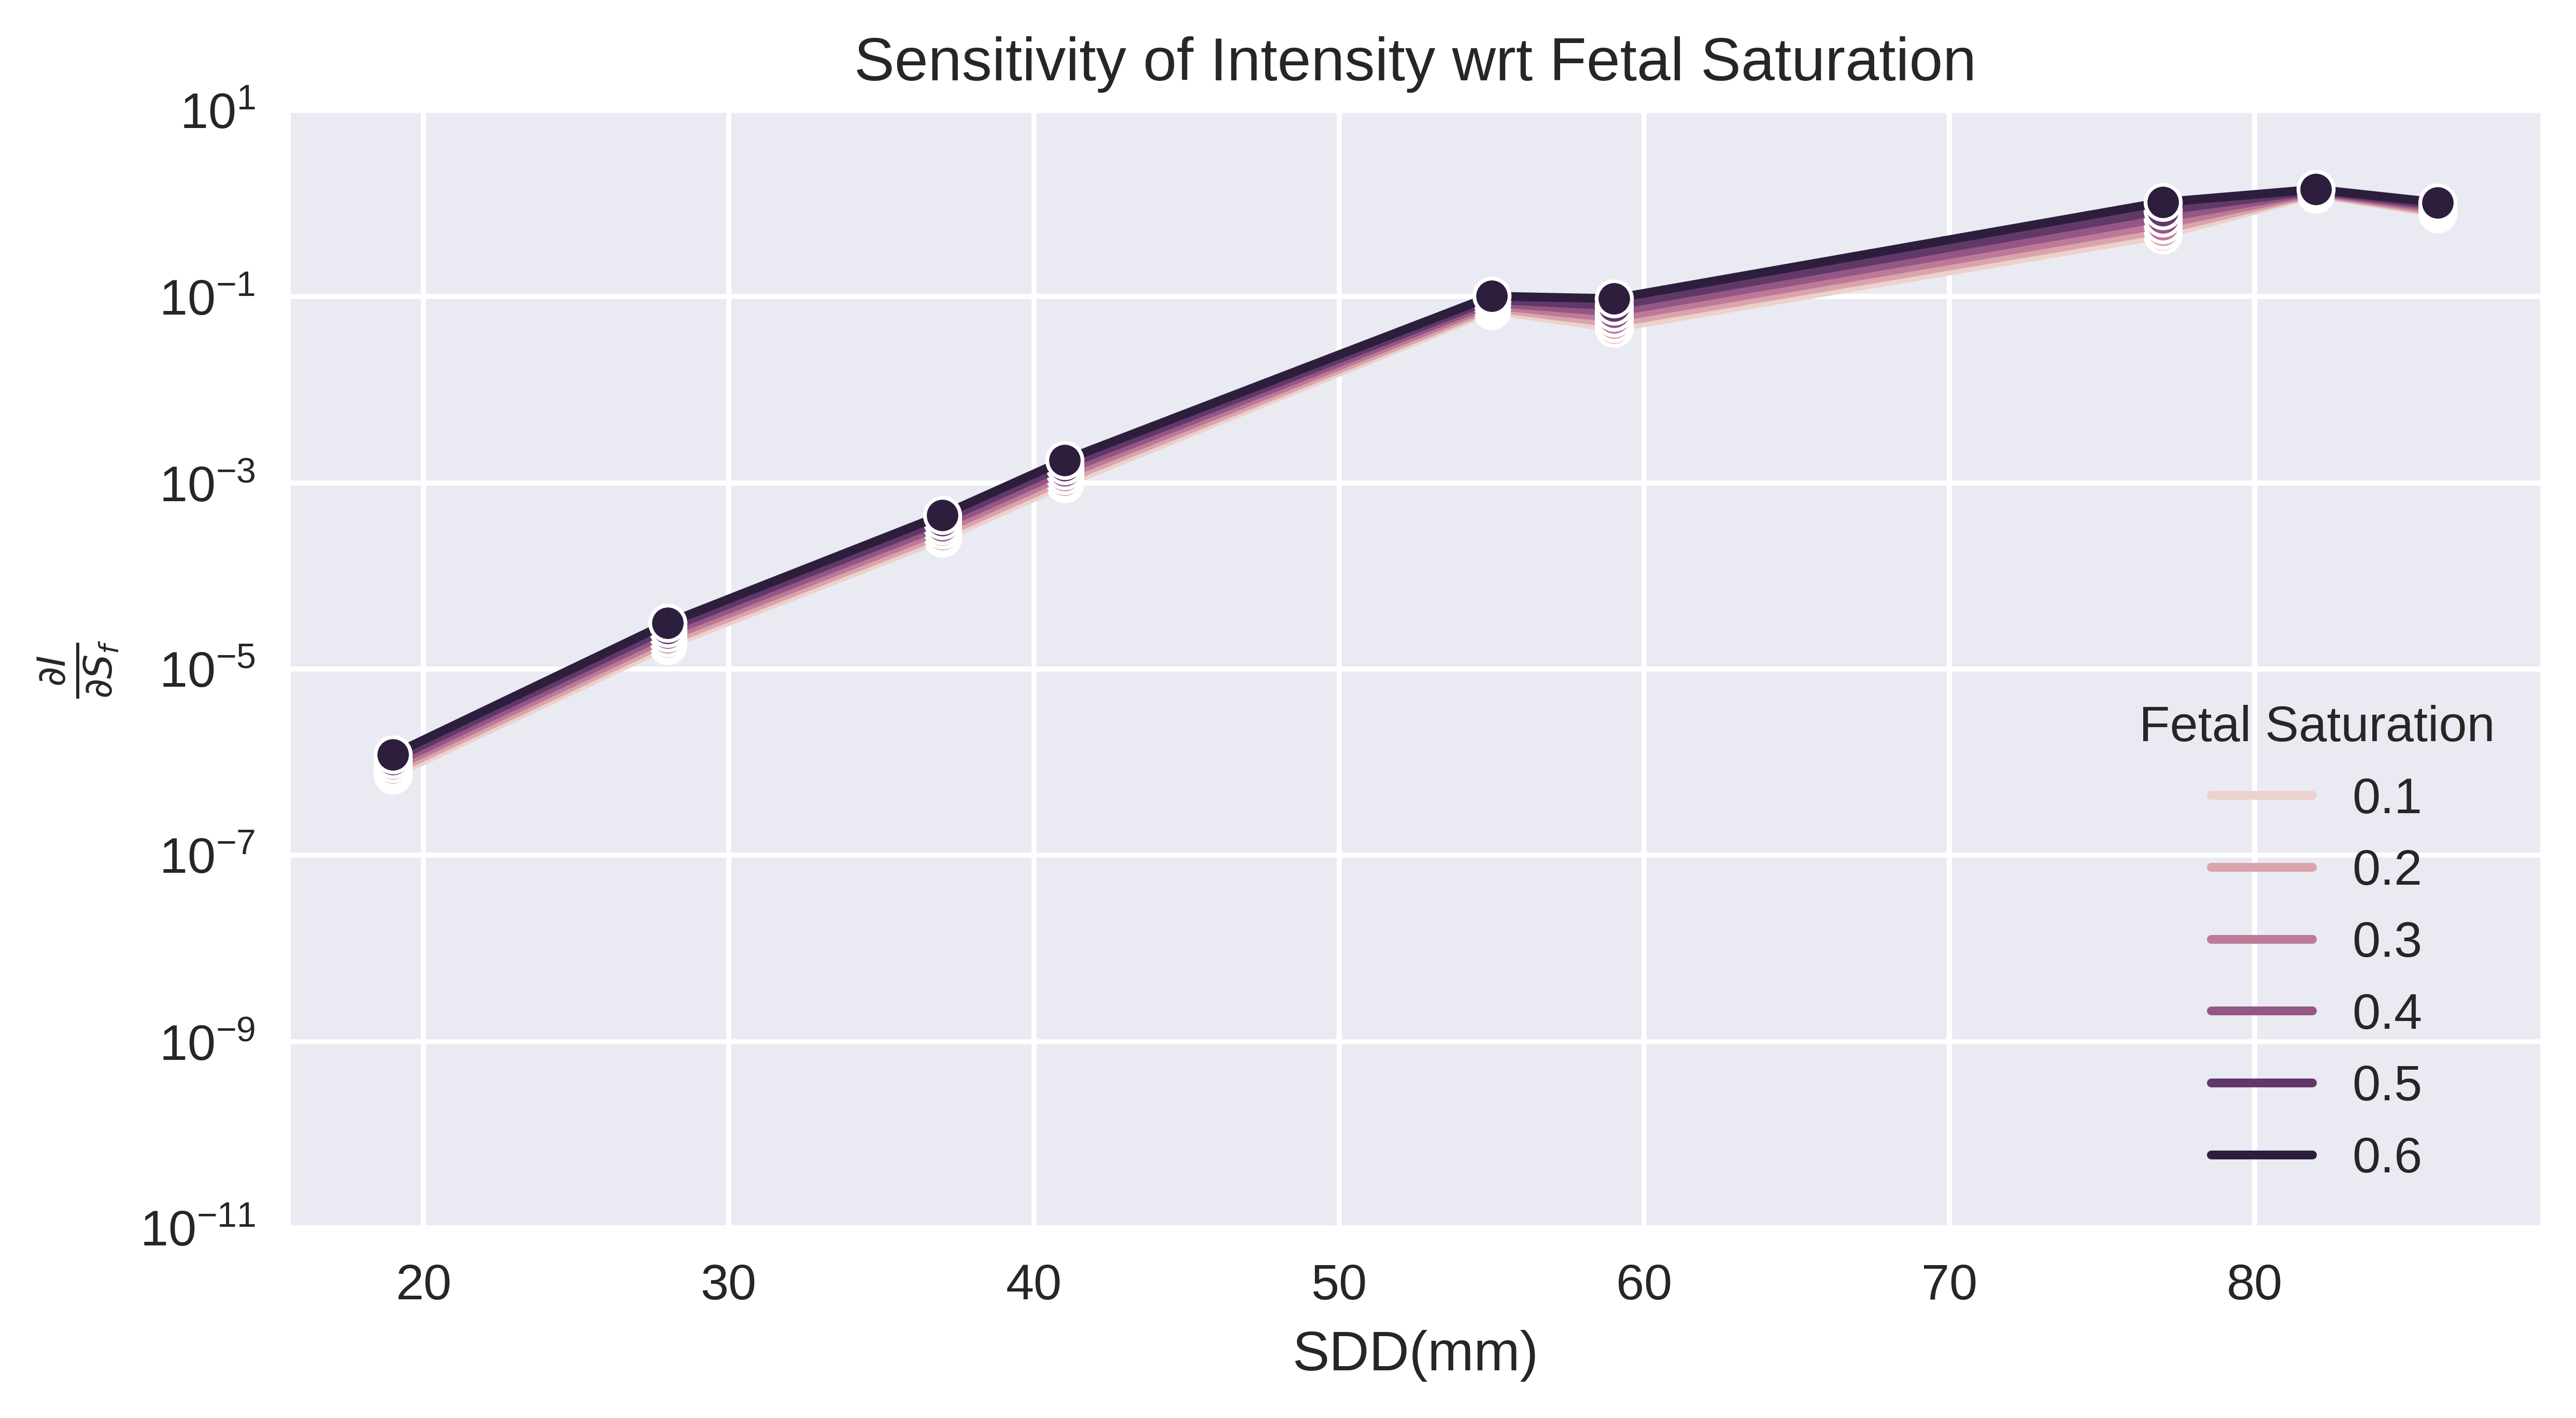

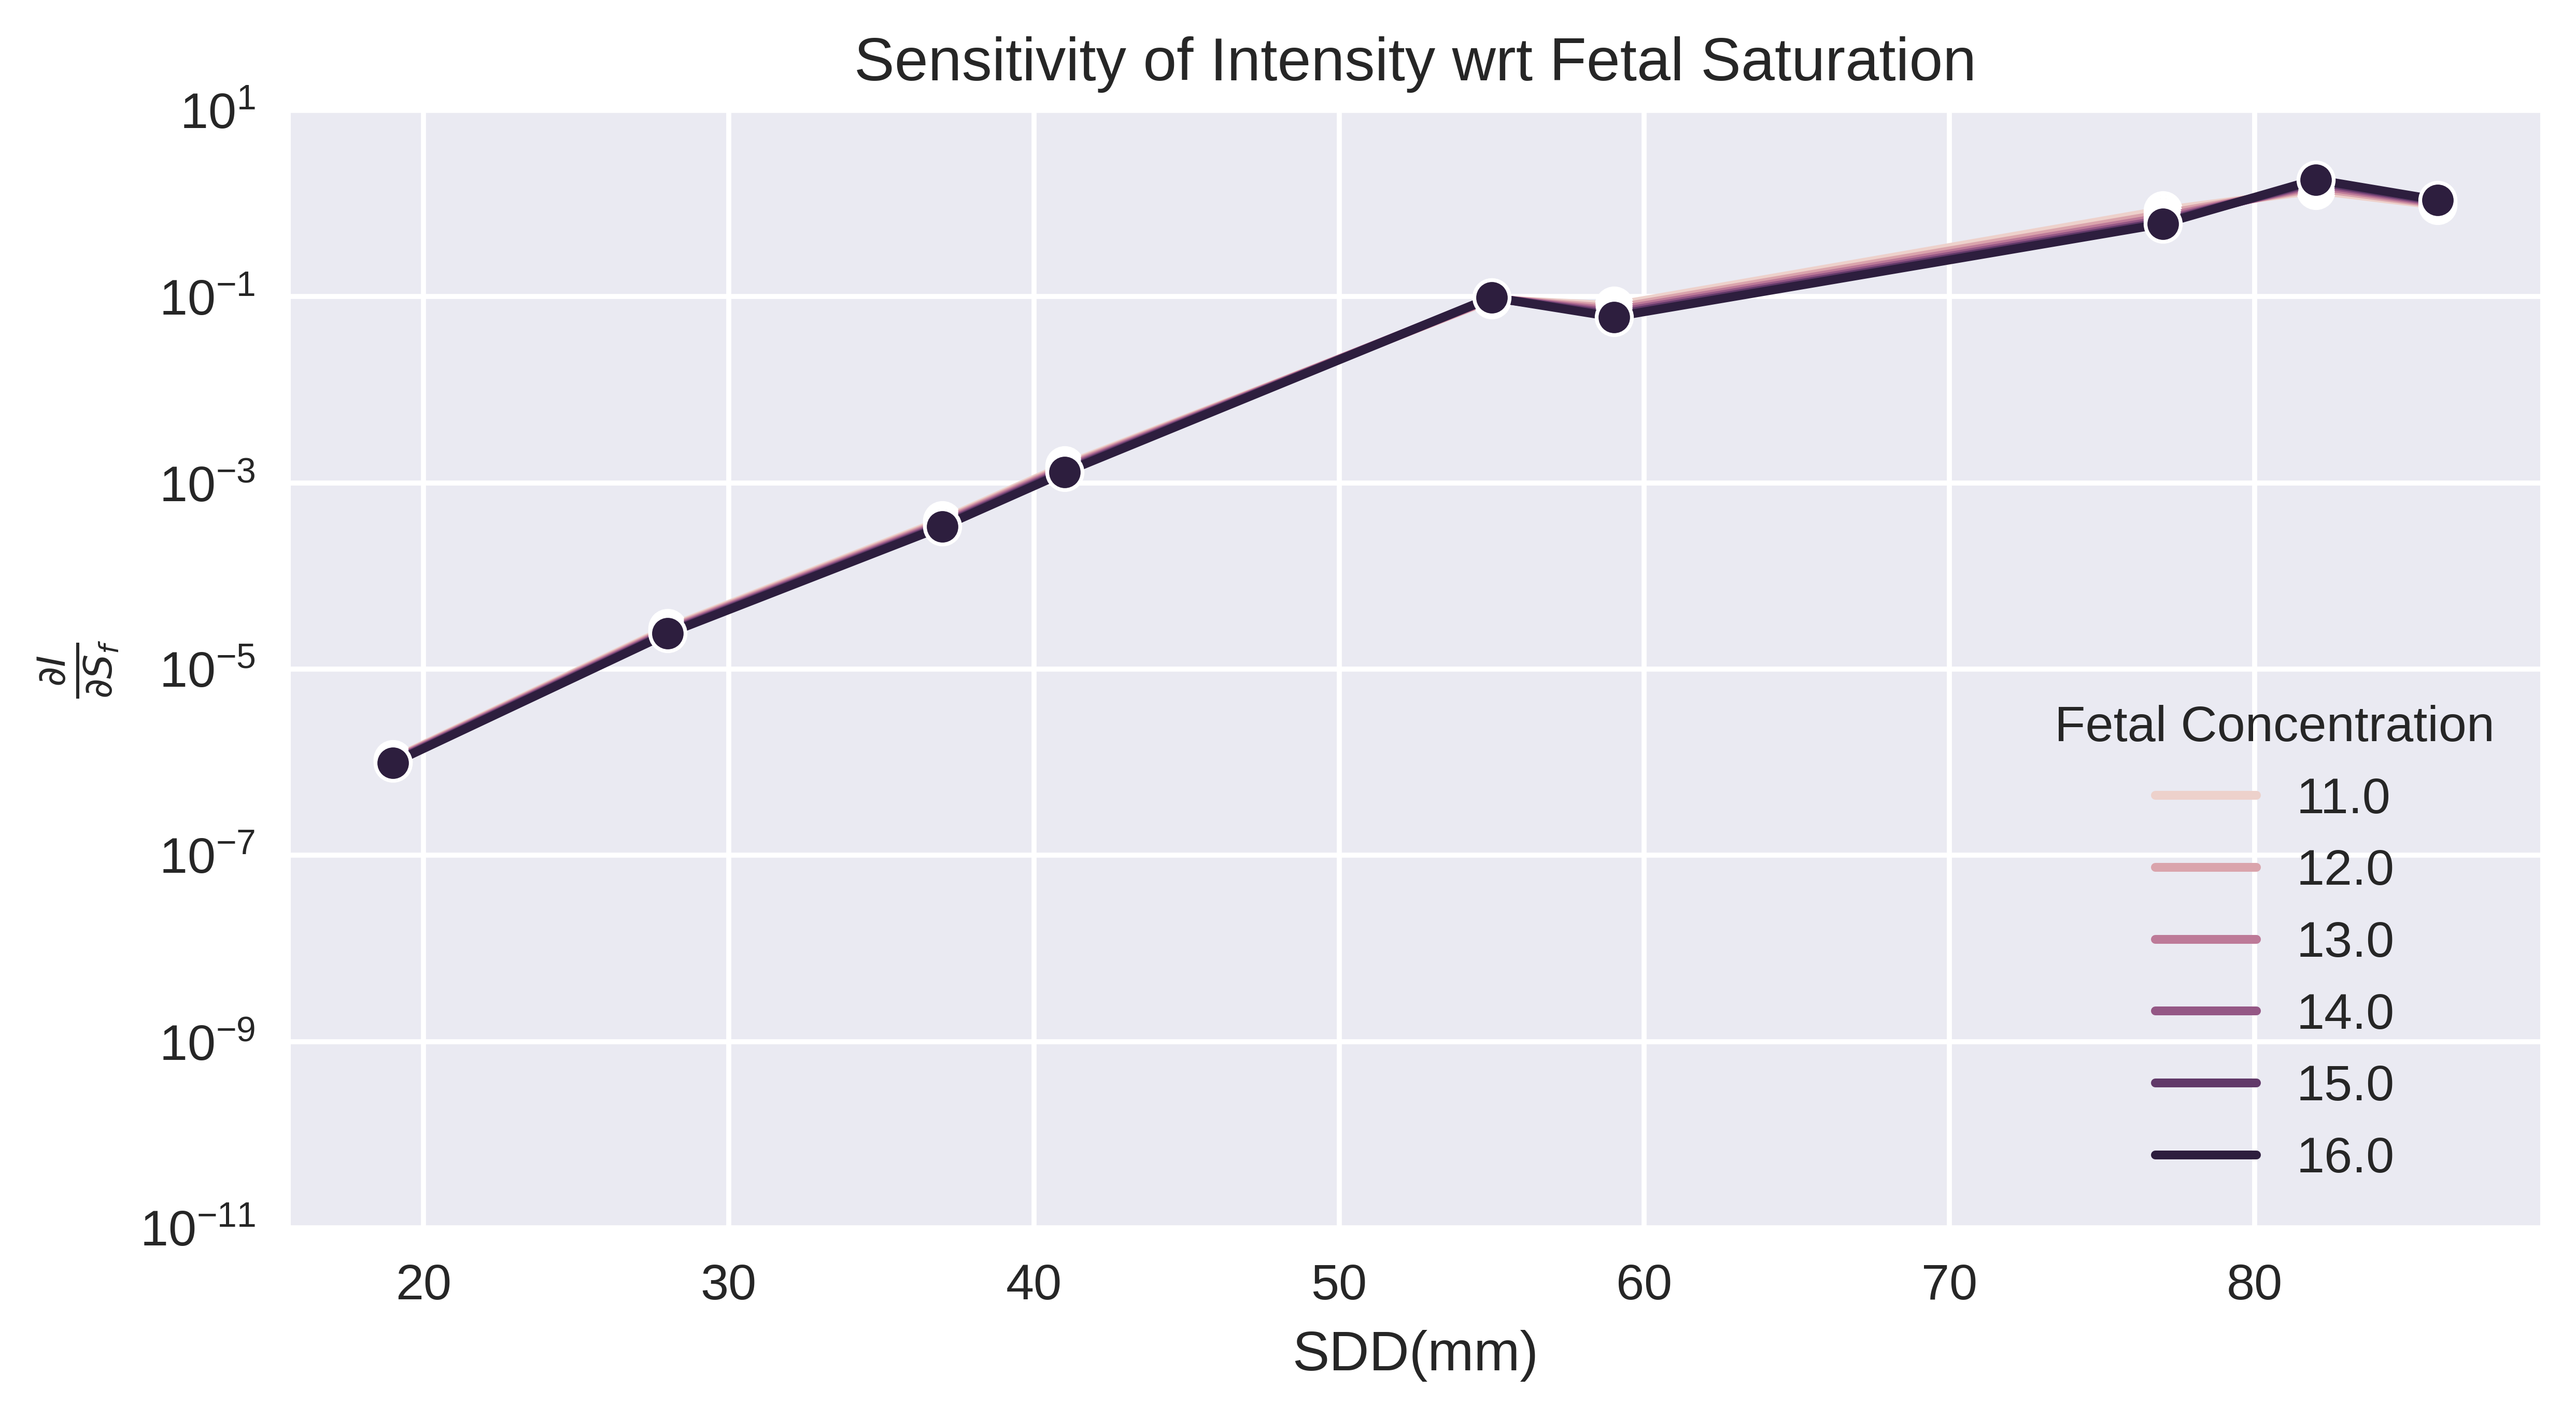

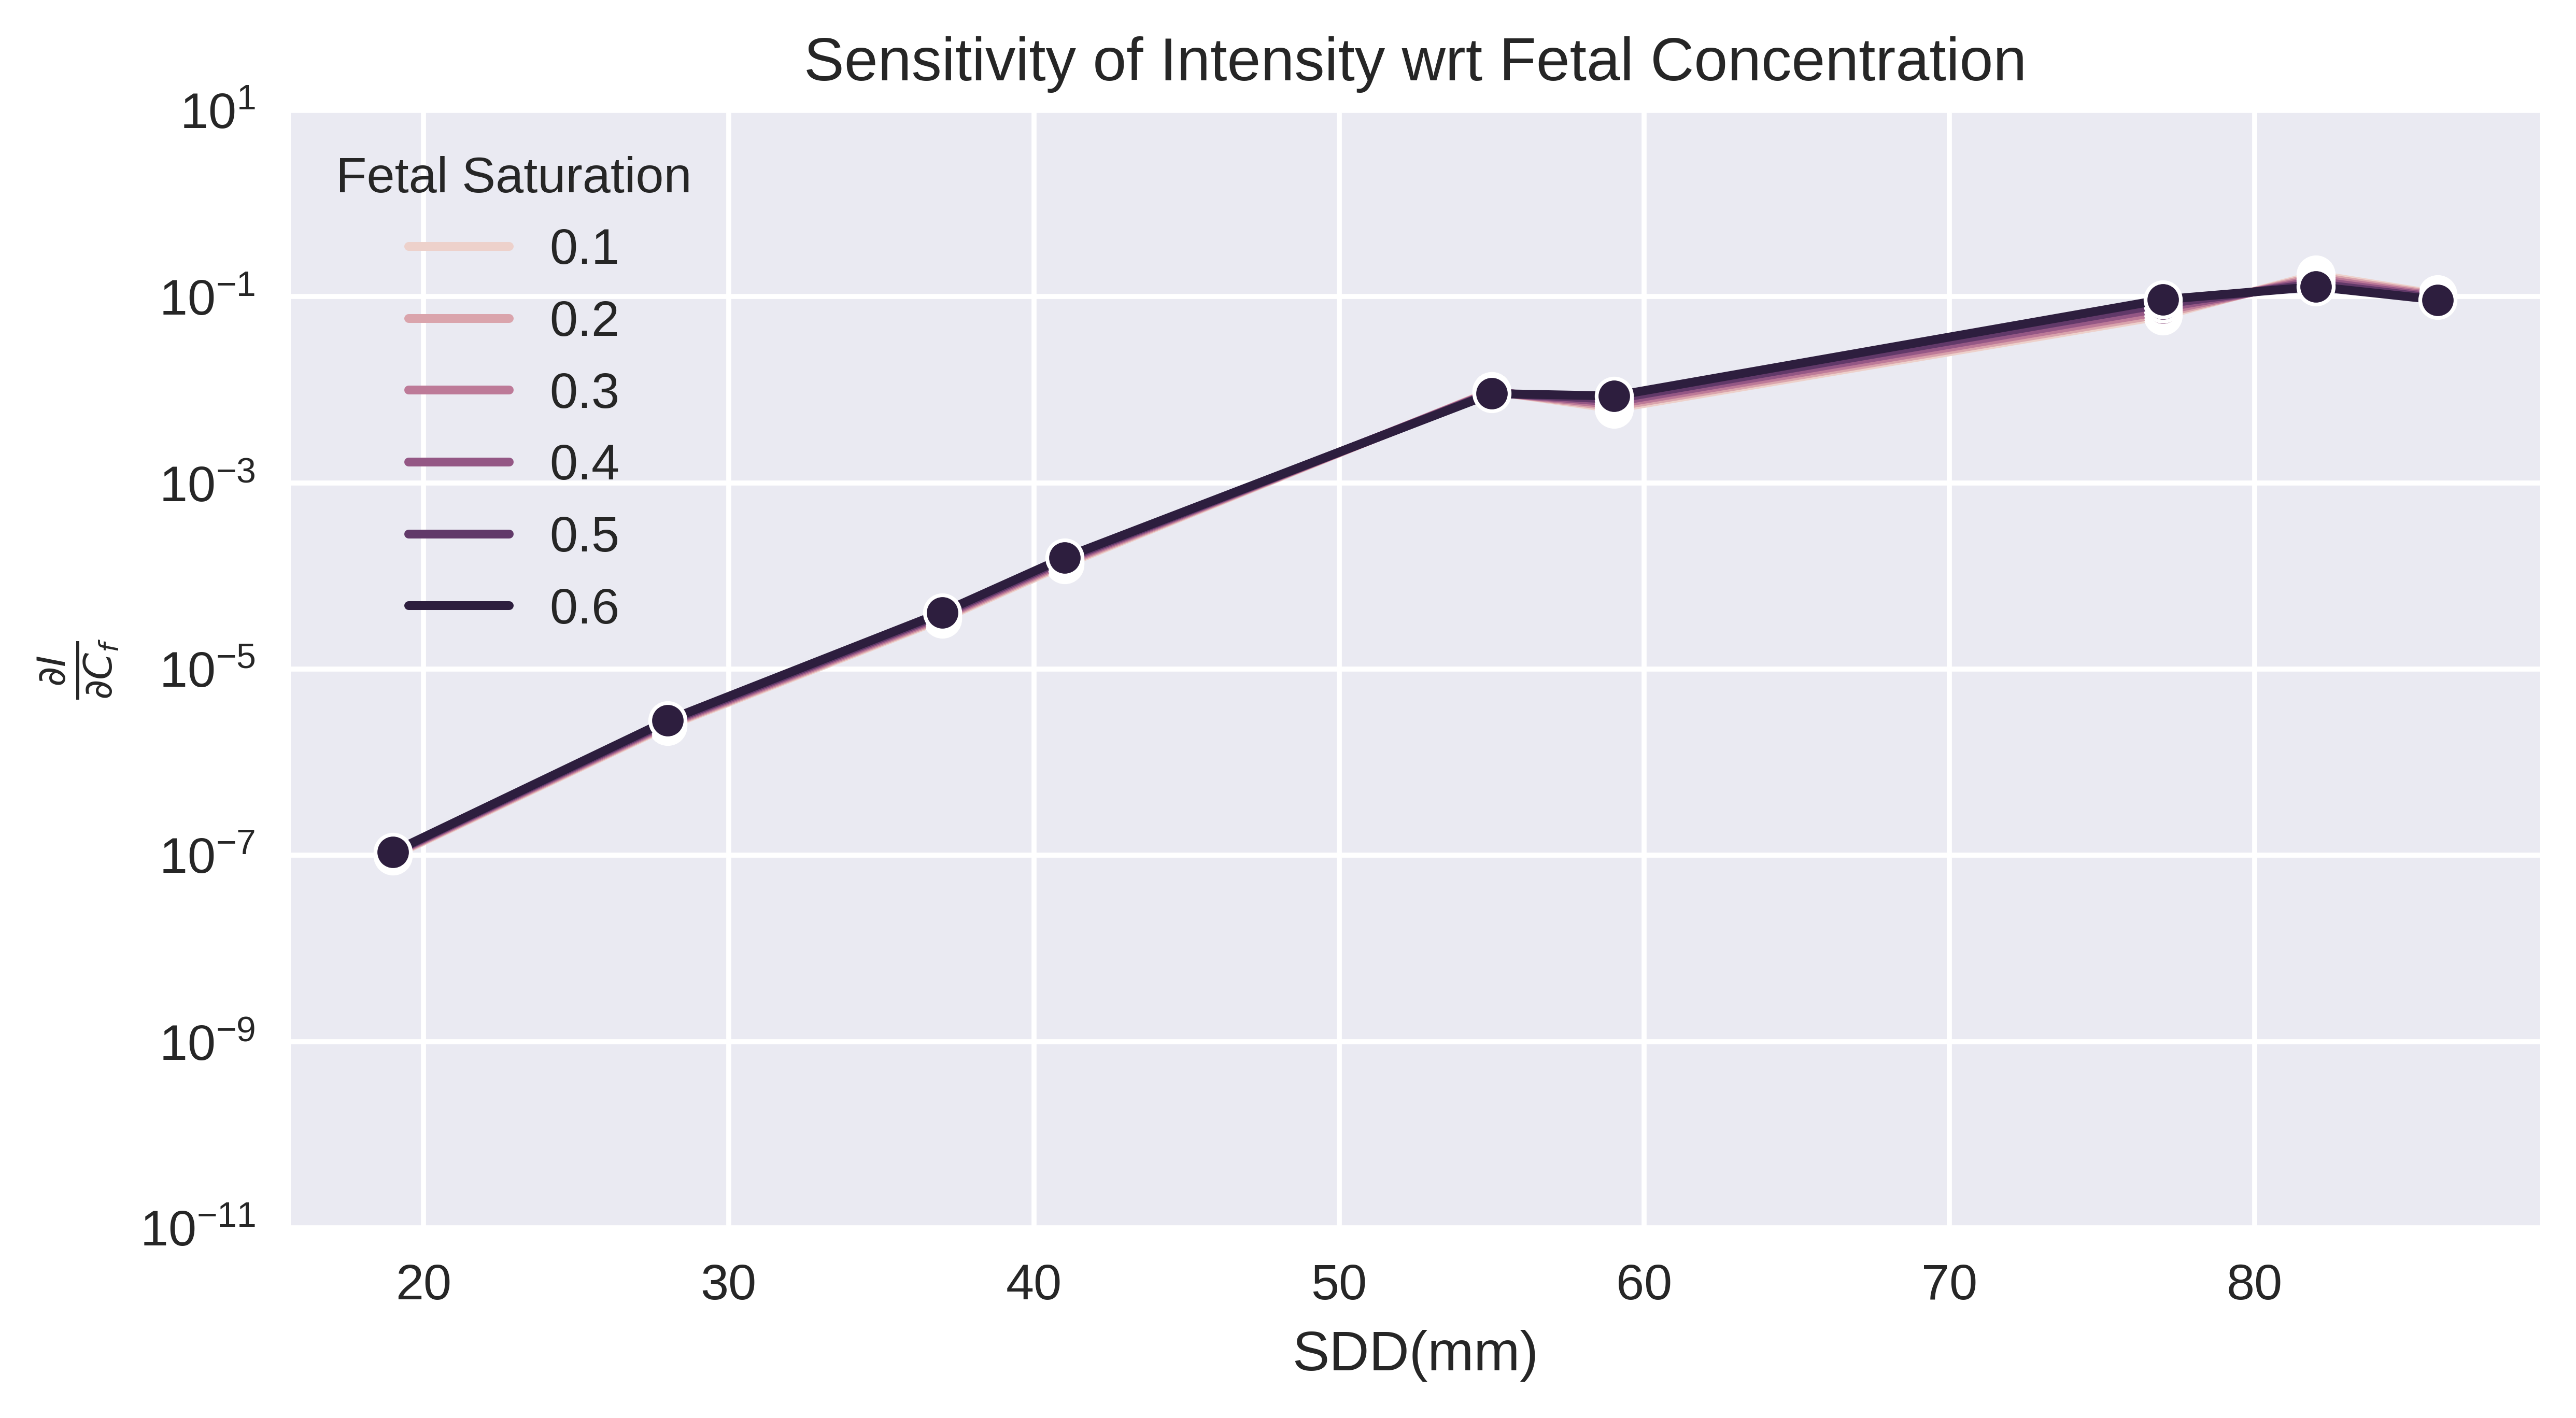

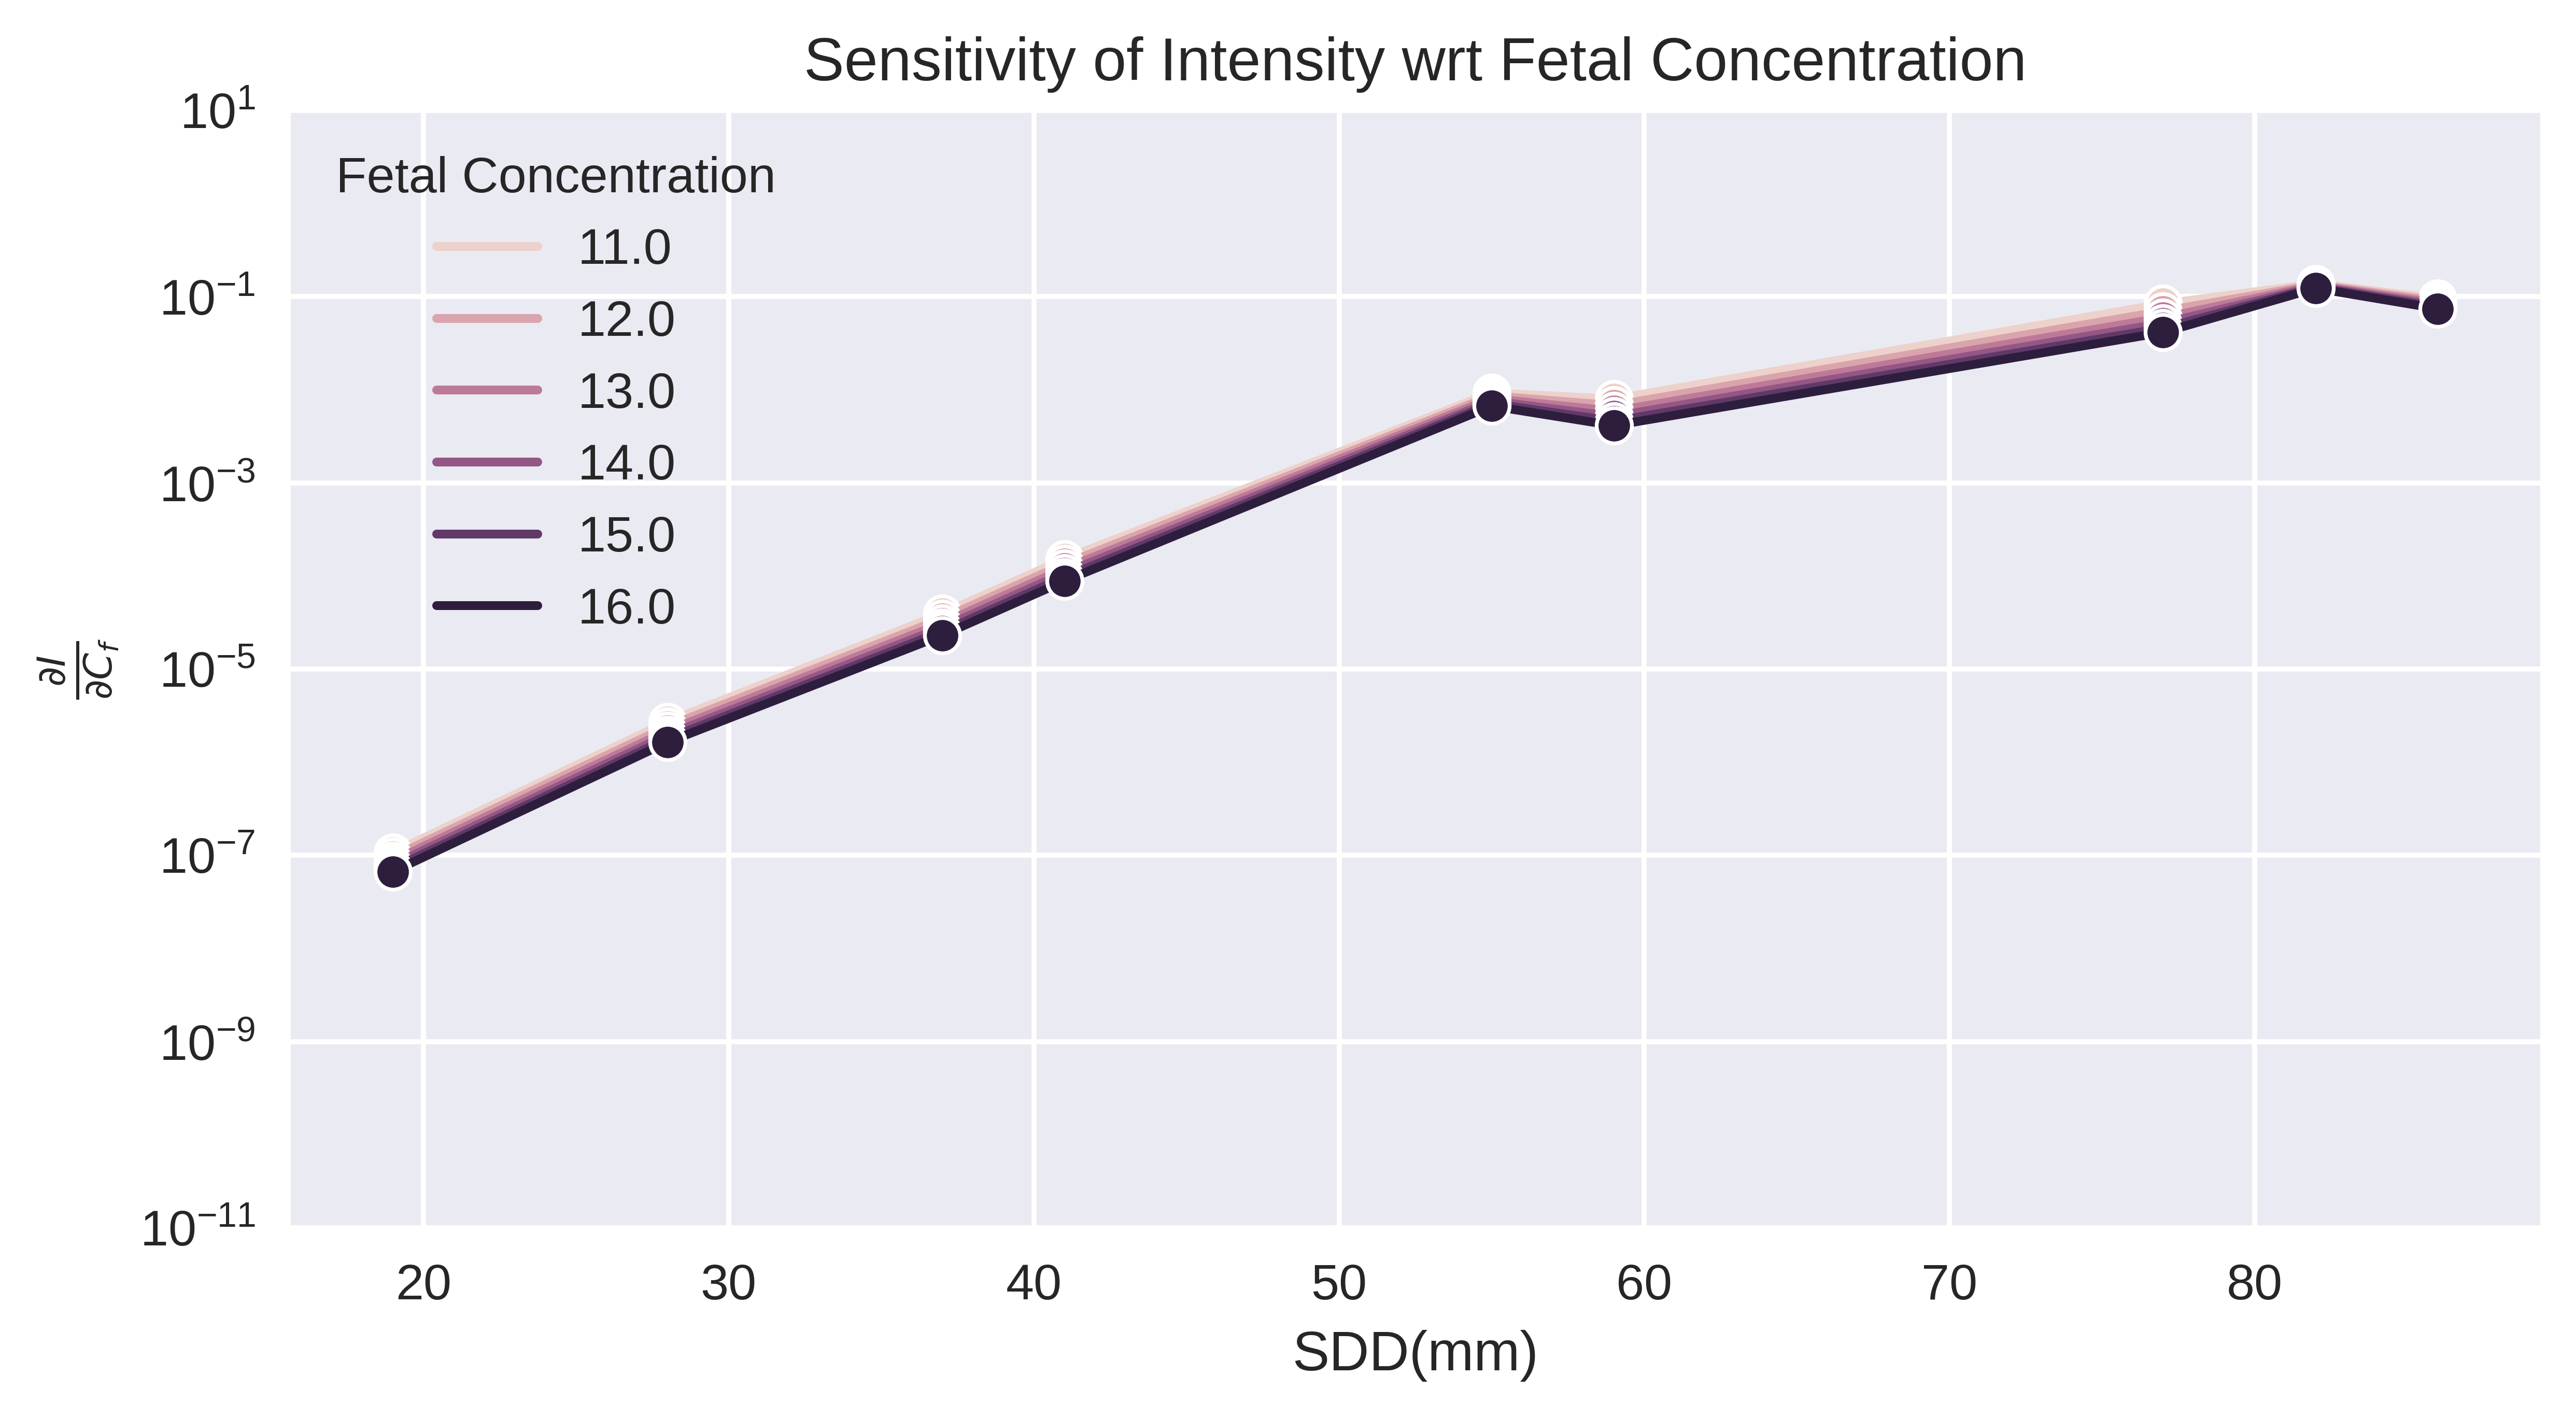

In [14]:
# Mandatory - Make all the derivatives positive
data_table['Derivative'] = data_table['Derivative'].abs()

partial_derivative_variable = ['Fetal Saturation', 'Fetal Saturation', 'Fetal Concentration', 'Fetal Concentration']
variable_tmp = ['Fetal Saturation', 'Fetal Concentration', 'Fetal Saturation', 'Fetal Concentration']
y_lablels = [r'$\frac{\partial I}{\partial S_f} $', r'$\frac{\partial I}{\partial S_f} $', r'$\frac{\partial I}{\partial C_f} $', r'$\frac{\partial I}{\partial C_f} $']
plot_tiltes = [f'Sensitivity of Intensity wrt {derivative}' for derivative in partial_derivative_variable]

for i in range(len(plot_tiltes)):
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    data_table_subset = data_table[data_table['Type'] == i + 1] # I made types 1 indexed for some stupid reason ...
    plot = sns.lineplot(data=data_table_subset, x='SDD', y='Derivative', hue=variable_tmp[i], marker='o')
    plt.title(plot_tiltes[i])
    plt.yscale('log')
    plt.xlabel('SDD(mm)')
    plt.ylabel(y_lablels[i])
    plt.ylim(1e-11, 10)